# Construction d'un index sur les mots 

In [1]:
# Exercice 2 : Construction d'un index sur les mots
# M2 MIASHS : projet Network Analysis for Information Retrieval

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import string
from tqdm import tqdm

# Scikit-learn pour le traitement de texte
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

# NLTK pour le stemming et stopwords
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Téléchargement des ressources NLTK nécessaires
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Configuration pour un meilleur affichage
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc190\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc190\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pc190\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# 1. Chargement des données traitées dans l'exercice 1
def load_processed_data(file_path):
    """
    Charge les données traitées lors de l'exercice 1.
    
    Args:
        file_path (str): Chemin du fichier pickle contenant le DataFrame
        
    Returns:
        pandas.DataFrame: DataFrame contenant les articles
    """
    try:
        df = pd.read_pickle(file_path)
        print(f"Données chargées avec succès. Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Erreur lors du chargement des données: {e}")
        return None

# 2. Préparation des textes pour l'indexation
def prepare_texts(df):
    """
    Prépare les textes des articles pour l'indexation.
    Combine le titre et le résumé de chaque article.
    
    Args:
        df (pandas.DataFrame): DataFrame contenant les articles
        
    Returns:
        pandas.Series: Série contenant les textes combinés
    """
    # Combiner le titre et le résumé pour chaque article
    # Si le résumé est manquant, utiliser uniquement le titre
    texts = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Préparation des textes"):
        title = row['title'] if pd.notna(row['title']) else ""
        abstract = row['abstract'] if pd.notna(row['abstract']) else ""
        combined_text = f"{title} {abstract}".strip()
        texts.append(combined_text)
    
    return pd.Series(texts)

# 3. Fonctions de prétraitement personnalisées
def custom_preprocessor(text):
    """
    Prétraite le texte brut.
    
    Args:
        text (str): Texte à prétraiter
        
    Returns:
        str: Texte prétraité
    """
    # Conversion en minuscules
    text = text.lower()
    
    # Suppression des chiffres et de la ponctuation
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Suppression des espaces multiples
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def stemming_tokenizer(text):
    """
    Tokenise et applique le stemming aux mots du texte.
    
    Args:
        text (str): Texte à tokeniser
        
    Returns:
        list: Liste de stems
    """
    stemmer = PorterStemmer()
    words = word_tokenize(text)
    return [stemmer.stem(word) for word in words]

def lemmatizing_tokenizer(text):
    """
    Tokenise et applique la lemmatisation aux mots du texte.
    
    Args:
        text (str): Texte à tokeniser
        
    Returns:
        list: Liste de lemmes
    """
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    return [lemmatizer.lemmatize(word) for word in words]

# 4. Création des vectoriseurs avec différentes configurations
def create_vectorizers(min_df=5, max_df=0.95, use_stemming=True, use_idf=True):
    """
    Crée des vectoriseurs avec différentes configurations.
    
    Args:
        min_df (int or float): Fréquence minimale des termes
        max_df (float): Fréquence maximale des termes
        use_stemming (bool): Utiliser le stemming ou la lemmatisation
        use_idf (bool): Utiliser TF-IDF ou simplement TF
        
    Returns:
        dict: Dictionnaire contenant les vectoriseurs
    """
    # Récupération des stop words en anglais
    stop_words = stopwords.words('english')
    
    # Ajout de stop words spécifiques au domaine scientifique
    scientific_stop_words = [
        'doi', 'fig', 'figure', 'et', 'al', 'paper', 'study', 'research',
        'method', 'results', 'analysis', 'data', 'proposed', 'approach',
        'using', 'based', 'used', 'show', 'shown', 'table', 'section'
    ]
    stop_words.extend(scientific_stop_words)
    
    # Définition du tokenizer en fonction de l'option choisie
    tokenizer = stemming_tokenizer if use_stemming else lemmatizing_tokenizer
    
    # Création des vectoriseurs
    vectorizers = {}
    
    # Vectoriseur TF (Count)
    vectorizers['tf'] = CountVectorizer(
        preprocessor=custom_preprocessor,
        tokenizer=tokenizer,
        stop_words=stop_words,
        min_df=min_df,
        max_df=max_df,
        ngram_range=(1, 1)  # Unigrammes uniquement
    )
    
    # Vectoriseur TF-IDF
    vectorizers['tfidf'] = TfidfVectorizer(
        preprocessor=custom_preprocessor,
        tokenizer=tokenizer,
        stop_words=stop_words,
        min_df=min_df,
        max_df=max_df,
        ngram_range=(1, 1),  # Unigrammes uniquement
        use_idf=use_idf,  # Si True, utilise TF-IDF, sinon utilise TF
        norm='l2'  # Normalisation L2
    )
    
    return vectorizers

# 5. Ajustement des vectoriseurs et création des matrices documents-termes
def create_document_term_matrices(texts, vectorizers):
    """
    Ajuste les vectoriseurs et crée les matrices documents-termes.
    
    Args:
        texts (pandas.Series): Série contenant les textes à vectoriser
        vectorizers (dict): Dictionnaire contenant les vectoriseurs
        
    Returns:
        dict: Dictionnaire contenant les matrices documents-termes et les vectoriseurs ajustés
    """
    result = {}
    
    for name, vectorizer in vectorizers.items():
        print(f"Création de la matrice documents-termes avec {name}...")
        dtm = vectorizer.fit_transform(texts)
        
        result[name] = {
            'vectorizer': vectorizer,
            'dtm': dtm,
            'feature_names': vectorizer.get_feature_names_out()
        }
        
        # Afficher quelques informations sur la matrice
        print(f"  Forme de la matrice: {dtm.shape}")
        print(f"  Taille du vocabulaire: {len(vectorizer.get_feature_names_out())}")
        print(f"  Densité de la matrice: {dtm.nnz / (dtm.shape[0] * dtm.shape[1]):.4f}")
    
    return result

# 6. Analyse du vocabulaire
def analyze_vocabulary(dtm_results):
    """
    Analyse le vocabulaire extrait des textes.
    
    Args:
        dtm_results (dict): Dictionnaire contenant les matrices documents-termes
        
    Returns:
        dict: Dictionnaire contenant les résultats de l'analyse
    """
    analysis_results = {}
    
    for name, result in dtm_results.items():
        dtm = result['dtm']
        feature_names = result['feature_names']
        
        # Calcul du nombre total d'occurrences pour chaque terme
        term_frequencies = np.asarray(dtm.sum(axis=0)).flatten()
        
        # Création d'un DataFrame pour faciliter l'analyse
        term_freq_df = pd.DataFrame({
            'term': feature_names,
            'frequency': term_frequencies
        })
        
        # Tri par fréquence décroissante
        term_freq_df = term_freq_df.sort_values('frequency', ascending=False)
        
        # Stockage des résultats
        analysis_results[name] = {
            'term_freq_df': term_freq_df,
            'total_occurrences': term_frequencies.sum(),
            'unique_terms': len(feature_names)
        }
        
        # Afficher les 20 termes les plus fréquents
        print(f"\nLes 20 termes les plus fréquents ({name}):")
        print(term_freq_df.head(20))
        
        # Afficher des statistiques générales
        print(f"\nNombre total d'occurrences de termes: {term_frequencies.sum()}")
        print(f"Nombre de termes uniques: {len(feature_names)}")
    
    return analysis_results

# 7. Visualisation de la distribution des fréquences de termes
def visualize_term_frequencies(analysis_results):
    """
    Visualise la distribution des fréquences de termes.
    
    Args:
        analysis_results (dict): Dictionnaire contenant les résultats de l'analyse
    """
    plt.figure(figsize=(15, 10))
    
    for i, (name, result) in enumerate(analysis_results.items()):
        term_freq_df = result['term_freq_df']
        
        # Top 30 termes
        plt.subplot(2, 2, i+1)
        top_terms = term_freq_df.head(30)
        ax = sns.barplot(x='frequency', y='term', data=top_terms)
        plt.title(f'Top 30 des termes les plus fréquents ({name})', fontsize=12)
        plt.tight_layout()
        
        # Distribution générale des fréquences
        plt.subplot(2, 2, i+3)
        term_freq_df['log_frequency'] = np.log1p(term_freq_df['frequency'])
        sns.histplot(term_freq_df['log_frequency'], bins=50, kde=True)
        plt.title(f'Distribution des fréquences de termes (log scale, {name})', fontsize=12)
        plt.xlabel('Log(fréquence + 1)')
        plt.ylabel('Nombre de termes')
    
    plt.tight_layout()
    plt.show()
    
    # Nuage de mots (optionnel) - nécessite wordcloud
    try:
        from wordcloud import WordCloud
        
        plt.figure(figsize=(15, 8))
        
        for i, (name, result) in enumerate(analysis_results.items()):
            term_freq_df = result['term_freq_df']
            
            # Création d'un dictionnaire {mot: fréquence}
            word_freq = dict(zip(term_freq_df['term'], term_freq_df['frequency']))
            
            # Création du nuage de mots
            plt.subplot(1, 2, i+1)
            wordcloud = WordCloud(width=800, height=400, background_color='white', 
                                 max_words=100, contour_width=3, contour_color='steelblue')
            wordcloud.generate_from_frequencies(word_freq)
            
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.title(f'Nuage de mots ({name})', fontsize=16)
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    except ImportError:
        print("Bibliothèque wordcloud non disponible. Nuage de mots ignoré.")

# 8. Visualisation des documents dans un espace réduit
def visualize_document_vectors(dtm_results, df, n_components=2, method='tsne', sample_size=2000):
    """
    Visualise les vecteurs documents dans un espace réduit.
    
    Args:
        dtm_results (dict): Dictionnaire contenant les matrices documents-termes
        df (pandas.DataFrame): DataFrame contenant les informations sur les articles
        n_components (int): Nombre de dimensions pour la réduction
        method (str): Méthode de réduction de dimensionnalité ('pca', 'svd' ou 'tsne')
        sample_size (int): Nombre d'échantillons à visualiser
    """
    # Vérifier si nous avons assez de documents
    if df.shape[0] > sample_size:
        # Échantillonnage aléatoire des indices
        sample_indices = np.random.choice(df.shape[0], sample_size, replace=False)
        df_sample = df.iloc[sample_indices]
    else:
        sample_indices = np.arange(df.shape[0])
        df_sample = df
    
    plt.figure(figsize=(15, 12))
    
    for i, (name, result) in enumerate(dtm_results.items()):
        # Sous-échantillonnage de la matrice documents-termes
        dtm_sample = result['dtm'][sample_indices]
        
        # Réduction de dimensionnalité
        if method == 'pca':
            reducer = PCA(n_components=n_components)
            reduced_vectors = reducer.fit_transform(dtm_sample.toarray())
            variance_explained = reducer.explained_variance_ratio_.sum()
            method_name = f"PCA (variance expliquée: {variance_explained:.2f})"
        elif method == 'svd':
            reducer = TruncatedSVD(n_components=n_components)
            reduced_vectors = reducer.fit_transform(dtm_sample)
            variance_explained = reducer.explained_variance_ratio_.sum()
            method_name = f"SVD (variance expliquée: {variance_explained:.2f})"
        elif method == 'tsne':
            # Pour t-SNE, on réduit d'abord avec SVD si la matrice est trop grande
            if dtm_sample.shape[1] > 100:
                svd = TruncatedSVD(n_components=100)
                dtm_sample = svd.fit_transform(dtm_sample)
            
            reducer = TSNE(n_components=n_components, perplexity=30, n_iter=1000, random_state=42)
            reduced_vectors = reducer.fit_transform(dtm_sample.toarray() if hasattr(dtm_sample, 'toarray') else dtm_sample)
            method_name = "t-SNE"
        
        # Visualisation en 2D
        plt.subplot(2, 2, i+1)
        
        # Coloration par journal/conférence (utiliser les principales venues)
        top_venues = df['venue'].value_counts().head(6).index.tolist()
        colors = []
        for venue in df_sample['venue']:
            if venue in top_venues:
                colors.append(top_venues.index(venue))
            else:
                colors.append(len(top_venues))  # Autre
        
        scatter = plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], 
                    c=colors, cmap='viridis', alpha=0.7, s=10)
        
        # Légende
        legend_labels = top_venues + ['Autre']
        plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, 
                  title="Venue", loc="upper right", fontsize='small')
        
        plt.title(f'Visualisation des documents ({name}, {method_name})', fontsize=12)
        plt.xlabel(f'Composante 1')
        plt.ylabel(f'Composante 2')
    
    plt.tight_layout()
    plt.show()

## Chargement des données

In [3]:
# 1. Chargement des données
input_file = "articles_processed.pkl"
print("1. Chargement des données...")
df = load_processed_data(input_file)

1. Chargement des données...
Données chargées avec succès. Shape: (79007, 11)


## Préparation des textes

In [4]:
# 2. Préparation des textes
print("\n2. Préparation des textes...")
texts = prepare_texts(df)


2. Préparation des textes...


Préparation des textes: 100%|██████████| 79007/79007 [00:03<00:00, 20984.42it/s]


## Création des vectoriseurs

In [5]:
# 3. Création des vectoriseurs
print("\n3. Création des vectoriseurs...")
# différentes configurations possible
vectorizers = create_vectorizers(min_df=5, max_df=0.95, use_stemming=True)
# Alternative avec lemmatisation: vectorizers = create_vectorizers(min_df=5, max_df=0.95, use_stemming=False)



3. Création des vectoriseurs...


## Création des matrices documents-termes

In [6]:
# 4. Création des matrices documents-termes
print("\n4. Création des matrices documents-termes...")
dtm_results = create_document_term_matrices(texts, vectorizers)


4. Création des matrices documents-termes...
Création de la matrice documents-termes avec tf...


c:\Users\pc190\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\pc190\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'analysi', 'ani', 'base', 'becaus', 'befor', 'doe', 'dure', 'figur', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'propos', 'result', 'studi', 'tabl', 'themselv', 'thi', 'use', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


  Forme de la matrice: (79007, 13763)
  Taille du vocabulaire: 13763
  Densité de la matrice: 0.0030
Création de la matrice documents-termes avec tfidf...
  Forme de la matrice: (79007, 13763)
  Taille du vocabulaire: 13763
  Densité de la matrice: 0.0030


## Analyse du vocabulaire

In [7]:
# 5. Analyse du vocabulaire
print("\n5. Analyse du vocabulaire...")
analysis_results = analyze_vocabulary(dtm_results)


5. Analyse du vocabulaire...

Les 20 termes les plus fréquents (tf):
            term  frequency
12186        thi      64572
12992        use      57930
909         base      44370
11902     system      40493
7490       model      40293
9492      propos      37266
7950     network      32628
7821           n      28650
296    algorithm      28135
10189     result      27614
8844     perform      25305
12253       time      24537
9729           r      23910
9429     problem      21970
2180      comput      18696
11594      studi      18165
2989      design      17880
5835      inform      17879
4742       gener      17321
9357     present      16936

Nombre total d'occurrences de termes: 4989221
Nombre de termes uniques: 13763

Les 20 termes les plus fréquents (tfidf):
            term    frequency
11902     system  1760.167330
12992        use  1732.161102
7490       model  1698.654209
909         base  1664.779353
7950     network  1635.940768
12186        thi  1443.513295
296    alg

## Visualisation des fréquences de termes


6. Visualisation des fréquences de termes...


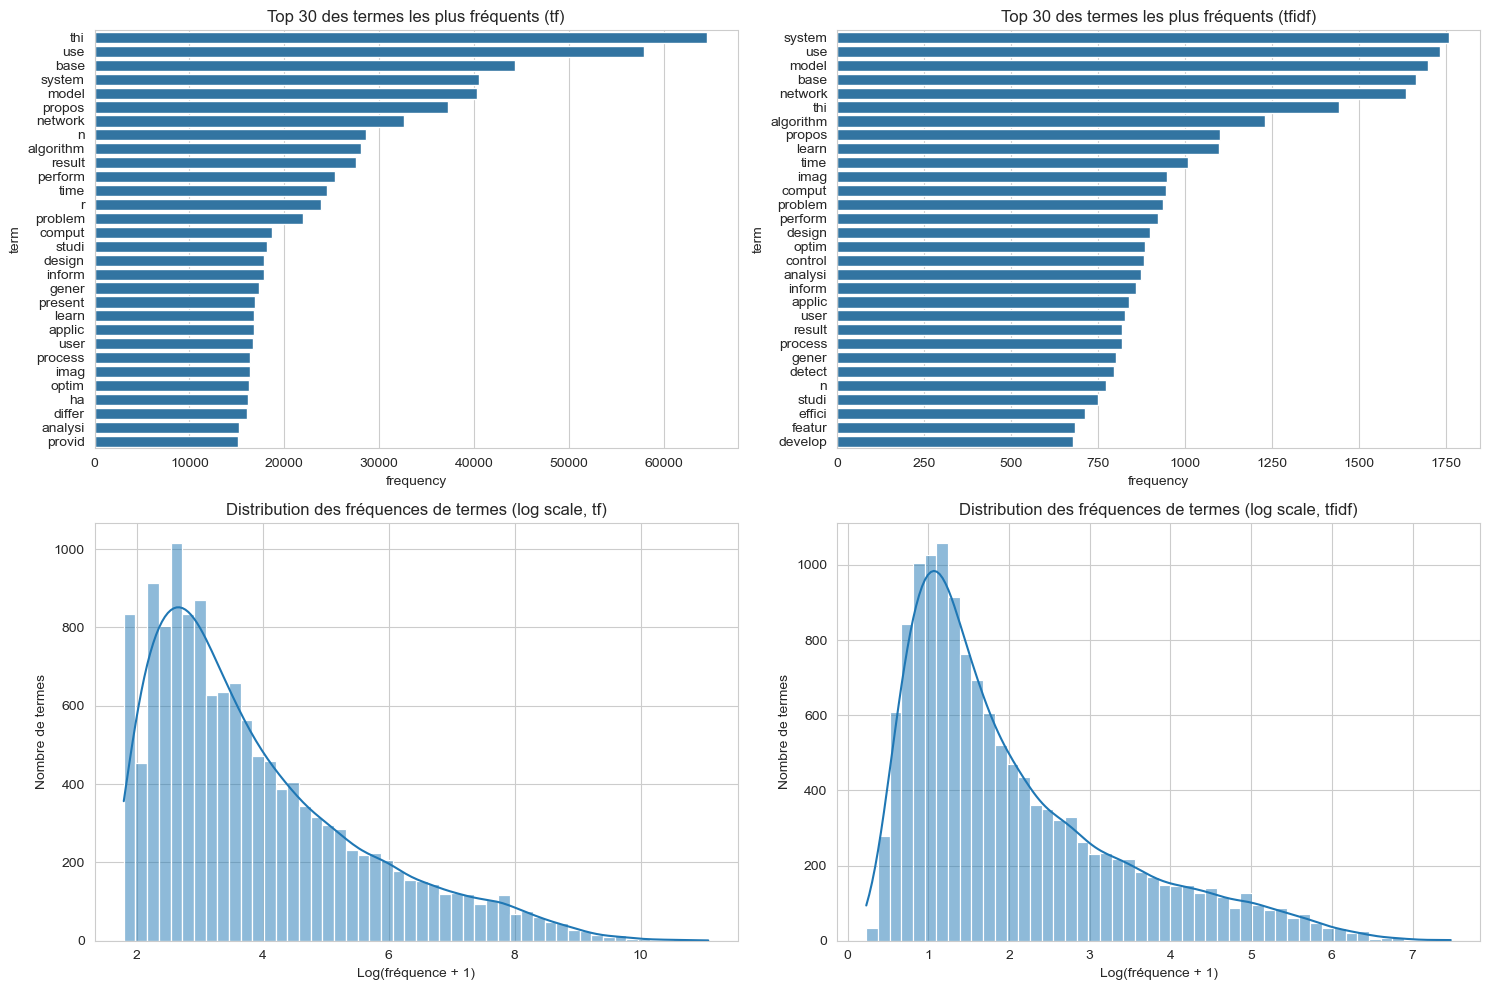

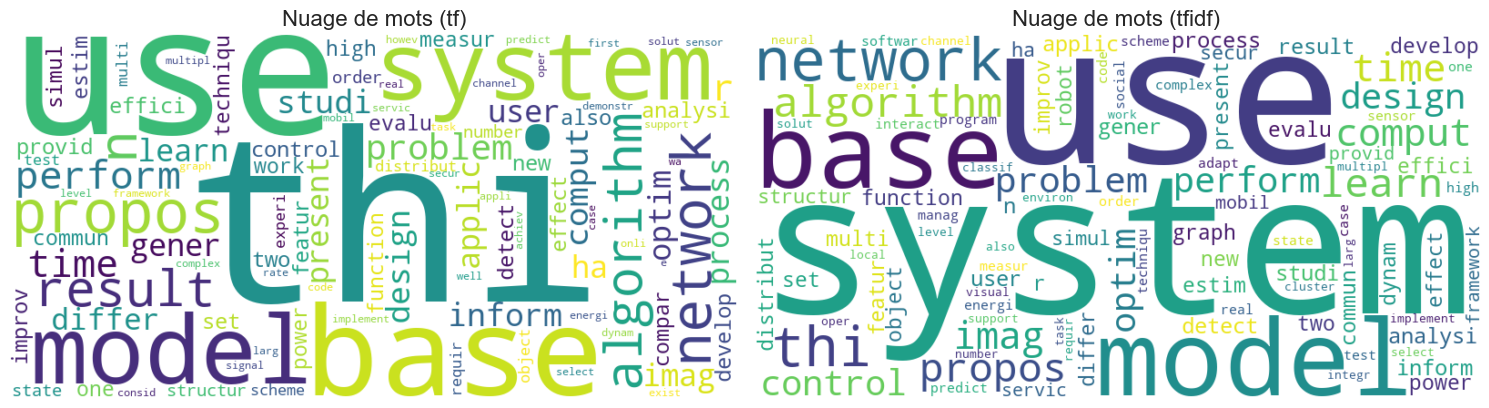

In [8]:
# 6. Visualisation des fréquences de termes
print("\n6. Visualisation des fréquences de termes...")
visualize_term_frequencies(analysis_results)

## Visualisation des documents - tsne


7. Visualisation des documents dans un espace réduit...


c:\Users\pc190\Anaconda\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\pc190\Anaconda\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


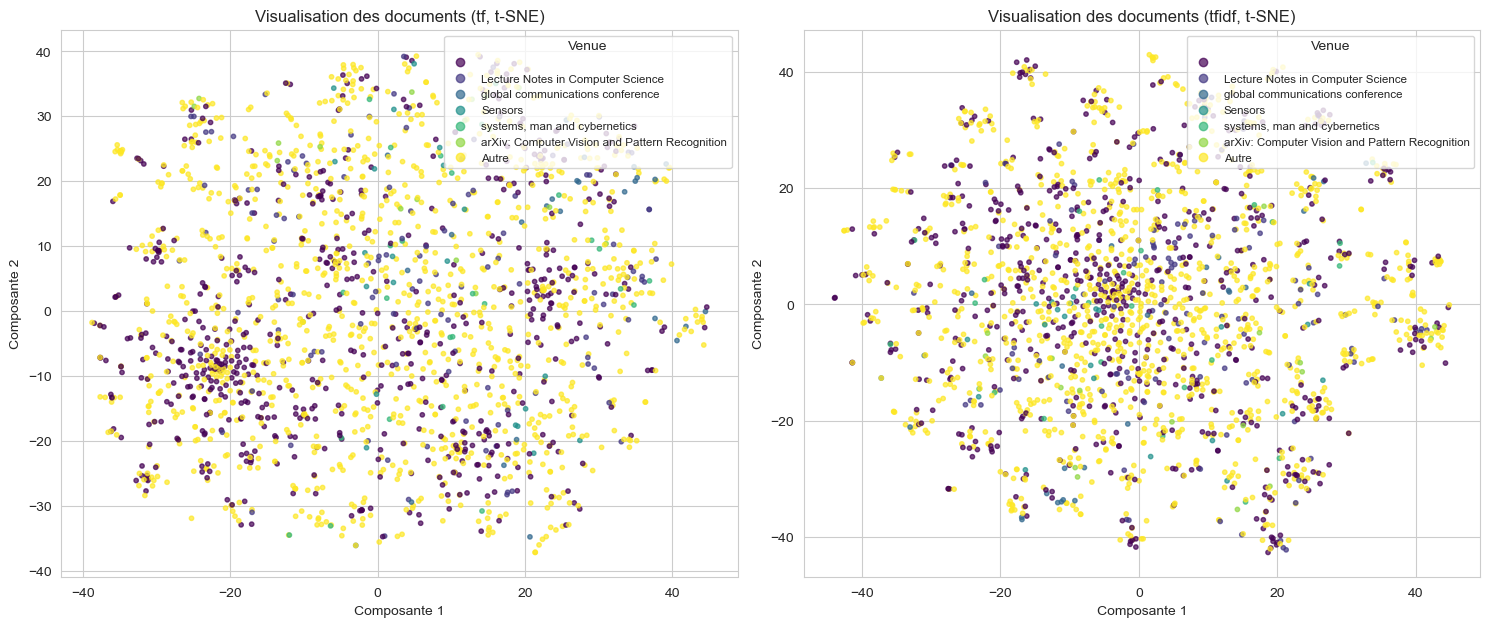

In [9]:
# 7. Visualisation des documents
print("\n7. Visualisation des documents dans un espace réduit...")
# Vous pouvez tester différentes méthodes: 'pca', 'svd', 'tsne'
visualize_document_vectors(dtm_results, df, method='tsne', sample_size=2000)

## Visualisation des documents - svd


7. Visualisation des documents dans un espace réduit...


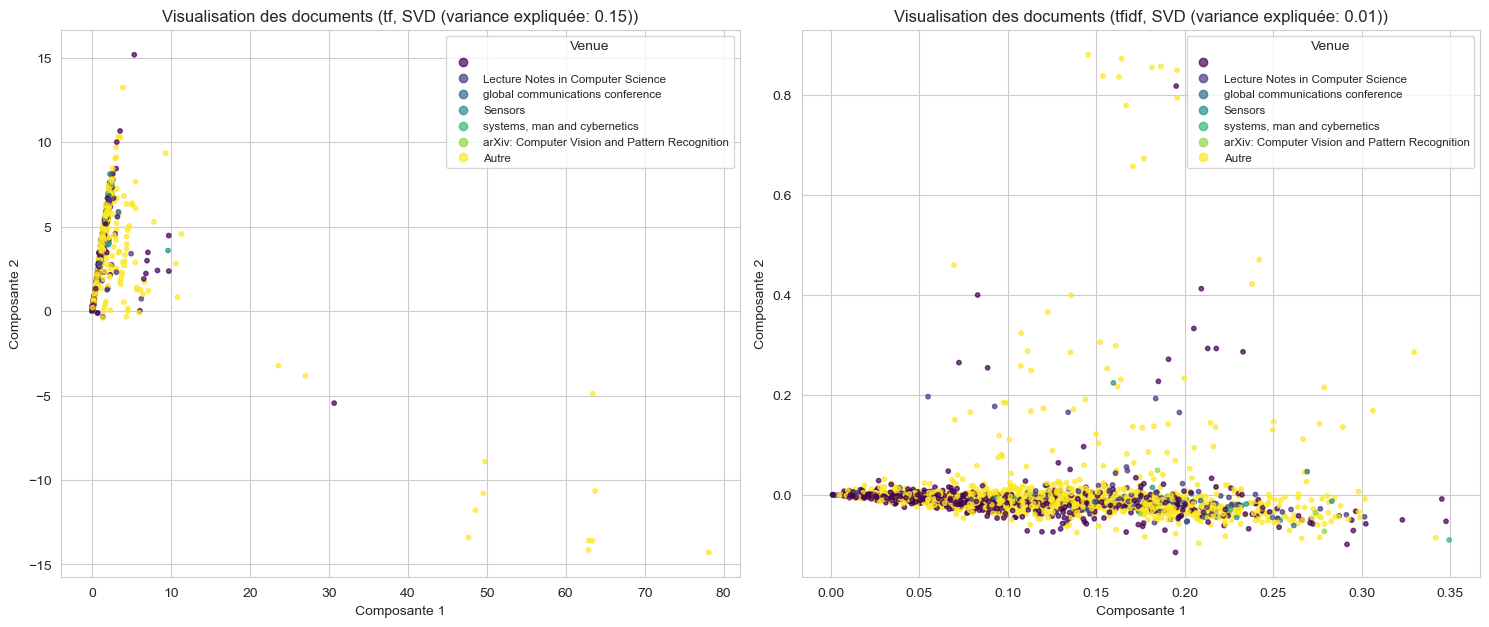

In [10]:
# 7. Visualisation des documents
print("\n7. Visualisation des documents dans un espace réduit...")
visualize_document_vectors(dtm_results, df, method='svd', sample_size=2000)

## Visualisation des documents - pca


7. Visualisation des documents dans un espace réduit...


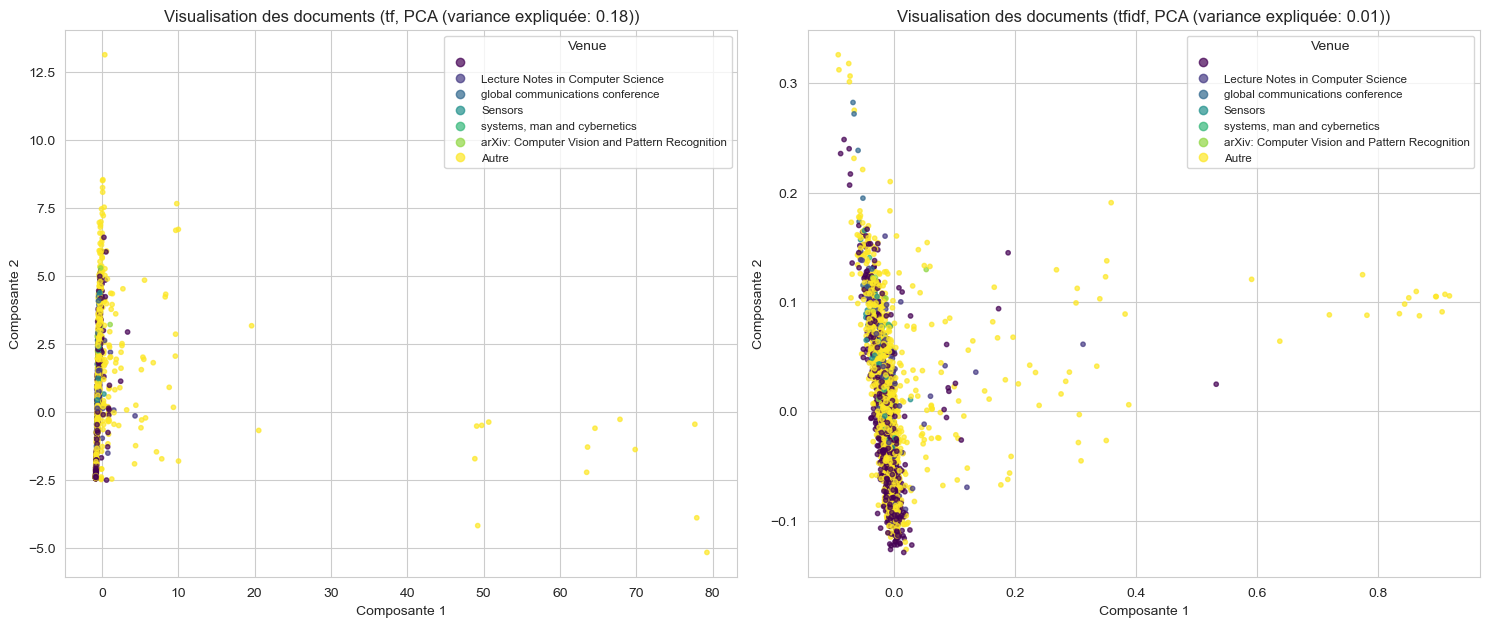

In [11]:
# 7. Visualisation des documents
print("\n7. Visualisation des documents dans un espace réduit...")
visualize_document_vectors(dtm_results, df, method='pca', sample_size=2000)